In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
df= pd.read_csv("fake news dataset.csv")
#df= pd.read_csv("news categorisation dataset.csv")

In [7]:
x = df.content.values
x = [str (item) for item in x]

y = df.label.values
# encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=1 ,shuffle=True)

In [9]:
# max_words = 100000
max_words = 10000
max_len = 150
# tokenizer create tokens for every word
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
# feed sequence for sequence modelling
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [19]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
84/84 [==============================] - 7s 87ms/step - loss: 0.2903 - accuracy: 0.8790 - val_loss: 0.3972 - val_accuracy: 0.8403


In [20]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [21]:
accr = model.evaluate( test_sequences_matrix,Y_test)
print(accr)

179/179 [==============================] - 2s 10ms/step - loss: 0.3985 - accuracy: 0.8367
[0.39852556586265564, 0.8367239832878113]


In [15]:
from sklearn.metrics import classification_report
lstmPredict =model.predict(test_sequences_matrix)

In [16]:
def decodeLabel(score):
    return 1 if score>0.5 else 0

lstmPredict = [decodeLabel(score) for score in lstmPredict]

In [17]:
x = (classification_report(Y_test,lstmPredict))
print(x)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3378
           1       0.86      0.71      0.78      2324

    accuracy                           0.84      5702
   macro avg       0.84      0.82      0.82      5702
weighted avg       0.84      0.84      0.83      5702



Text(0.5, 1.0, 'LSTM')

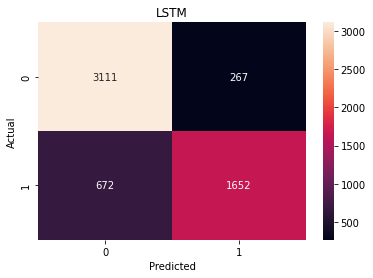

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,lstmPredict)

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM')